In [7]:
# "A segment-based fitness measure for capturing repetitive structs of music recordings"
# by Meinard Müller, Peter Grosche, Nanzhu Jiang

import numpy as np
import librosa
import matplotlib.pyplot as plt
from ssm import ssm

class audio_thumb_muller:
    def __init__(self, audio_path, t = 'chroma', k = 10):
        self.ssm = ssm(audio_path, k, t)

        # S = np.array([[0.1, 1, 0.3, 0.4, 0.5],
        #               [0.3, 0.3, 1, 0.6, 0.5],
        #               [0.6, 0.4, 0.6, 1, 0.3],
        #               [0.7, 0.5, 0.5, 0.3, 1],
        #               [0.1, 1, 0.3, 0.4, 0.5],
        #               [0.3, 0.3, 1, 0.6, 0.5],
        #               [0.6, 0.4, 0.6, 1, 0.3],
        #               [0.7, 0.5, 0.5, 0.3, 1]])
        # self.max_path_family(S, 4)

    def calculate_path(self, pos, D, Sa):
        [N, M] = D.shape
        path = []
        new_path = []
        path_alpha = []
        path.append(pos)
        (i, j) = pos
        ok = 1
        while(ok):
            tmp = []
            if j == 0 and i < N - 1:
                if D[i + 1, j] > D[i + 1, M - 1]:
                    #path.append((i + 1, j))
                    (i, j) = i + 1, j
                else:
                    path.append((i + 1, M - 1))
                    (i, j) = i + 1, M - 1
                    path_alpha.append(path.copy())
                    #path = []

                #path.append((i + 1, j) if D[i + 1, j] > D[i + 1, M - 1] else (i + 1, M - 1))
                #(i, j) = (i + 1, j) if D[i + 1, j] > D[i + 1, M - 1] else (i + 1, M - 1)
            elif j == 1 and i < N - 1:
                path.append((i, j))
                (i, j) = (i, j - 1)
            else:
                if i + 1 < N and j - 1 >= 0 and Sa[N - 1 - (i + 1), j - 2] > 0 : tmp.append((D[i + 1, j - 1], (i + 1, j - 1)))
                if i + 1 < N and j - 2 >= 0 and Sa[N - 1 - (i + 1), j - 3] > 0 : tmp.append((D[i + 1, j - 2], (i + 1, j - 2)))
                if i + 2 < N and j - 1 >= 0 and Sa[N - 1 - (i + 2), j - 2] > 0 : tmp.append((D[i + 2, j - 1], (i + 2, j - 1)))

                if tmp != []:
                    pos = max(tmp, key = lambda item:item[0])
                    path.append(pos[1])
                    i, j = pos[1]
                #elif path != []:
                #    xmax = max(path, key = lambda item:item[1])
                #    xmin = min(path, key = lambda item:item[1])
                #    if xmax[1] + xmin[1] == M - 1 or xmax[1] + xmin[1] == M - 2:
                #        path_alpha.append(path.copy())
                #    ok = 0
                else:
                    j = j - 1
                
                
                    
            if i == N - 1 and j == 0:
                ok = 0
            #print(i, j)

        for path in path_alpha:
            for x in path:
                new_path.append((N - 1 - x[0], x[1] - 1))
        return new_path

    ## Verificar isso aqui!
    def calculate_coverage(self, path_family, alpha, N):
        gamma = len(path_family) - len(path_family)/alpha
        return (gamma - alpha)/N

    def calculate_score(self, path_family, score_opt, alpha):
        return (score_opt - alpha)/len(path_family)

    def calculate_fitness(self, gamma, mi):
        return 2*(gamma * mi/(gamma + mi))

    def print_status(self, M, low, alpha):
        pct = 100*low/(M - alpha)
        print("{0:.2f}".format(pct), end = ' ')


    def visualize(self, S):
        plt.figure(figsize=(12, 8))
        librosa.display.specshow(S, x_axis='frames', y_axis='frames', n_xticks=12)
        plt.title('SSM')
        plt.set_cmap('hot_r')
        plt.colorbar()
        plt.show()


    def display_path(self, path_family, low):
        S = self.ssm.s.copy()
        new_cells = [(cell[0], cell[1] + low) for cell in path_family]
        for cell in new_cells:
            S[cell] = 5
        self.visualize(S)

    def max_path_family(self, S, alpha):
        [N, M] = S.shape
        D = np.zeros((N, alpha + 1))
        fitness_list = []
        for low in range(0, M - alpha + 1):
            Sa = S[:, low:low + alpha]
            D[N - 1, 2:alpha + 1] = -np.inf
            for i in range(N - 1, -1, -1):
                for j in range(alpha + 1):
                    if (j == 0 and i + 1 < N):
                        D[i, j] = max(D[i + 1,0], D[i + 1, alpha])
                    elif (j == 1):
                        D[i, j] = D[i, 0] + Sa[N - 1 - i, 0]
                    elif (i != N - 1 and j != 0):
                        D[i, j] = Sa[N - 1 - i, j - 1] + max(D[i + 1, j - 1] if i + 1 < N and j - 1 > 0 else 0,
                                                             D[i + 1, j - 2] if i + 1 < N and j - 2 > 0 else 0,
                                                             D[i + 2, j - 1] if i + 2 < N and j - 1 > 0 else 0)
            possible_max = [D[0, alpha], D[0, 0]]
            score_opt = max(possible_max)
            arg = np.argmax(possible_max)
            path_family = self.calculate_path((0, 0) if arg else (0, alpha), D, Sa)
            gamma = self.calculate_coverage(path_family, alpha, N)
            mi = self.calculate_score(path_family, score_opt, alpha)
            fitness = self.calculate_fitness(gamma, mi)
            fitness_list.append((fitness, low))
            self.print_status(M, low, alpha)
            self.display_path(path_family, low)
        return fitness_list

    def thumb_alpha(self, alpha):
        fitness_list = self.max_path_family(self.ssm.s, alpha)
        (max_fit, max_low) = max(fitness_list, key = lambda item:item[0])
        print("Thumbnail init: " + str(self.frame_to_time(max_low)) + " with: " + str(max_fit) + " of fitness value.")

    def thumb_time(self, time):
        fitness_list = self.max_path_family(self.ssm.s, self.time_to_frame(time))
        (max_fit, max_low) = max(fitness_list, key = lambda item:item[0])
        print("Thumbnail init: " + str(self.frame_to_time(max_low)) + " with: " + str(max_fit) + " of fitness value.")

    def frame_to_time(self, f):
        dt = self.ssm.duration/self.ssm.s.shape[0]
        return dt*f

    def time_to_frame(self, time):
        df = self.ssm.s.shape[0]/self.ssm.duration
        return int(df*time)


In [8]:
at = audio_thumb_muller('wav/sun.wav', k = 10)

Calculating features...
Features calculated.
Calculating SSM...
SSM calculated.


0.00 

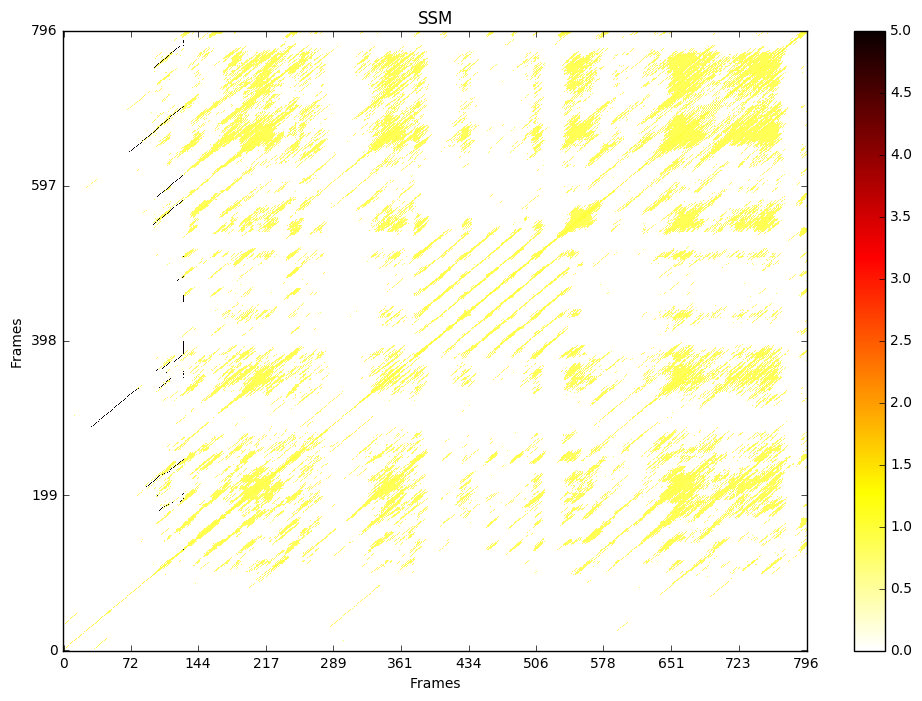

0.15 

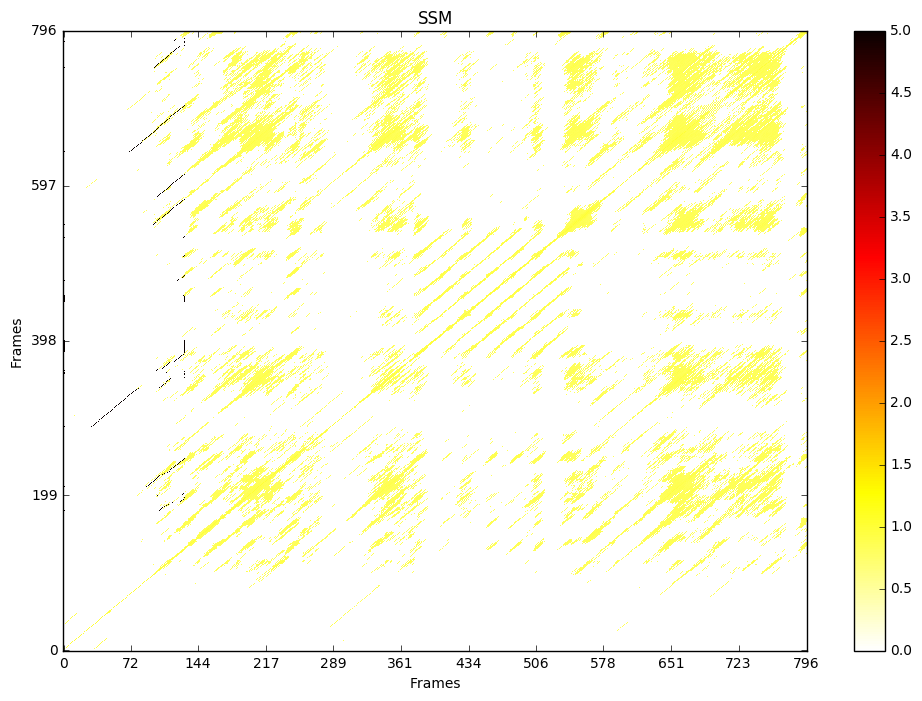

0.30 

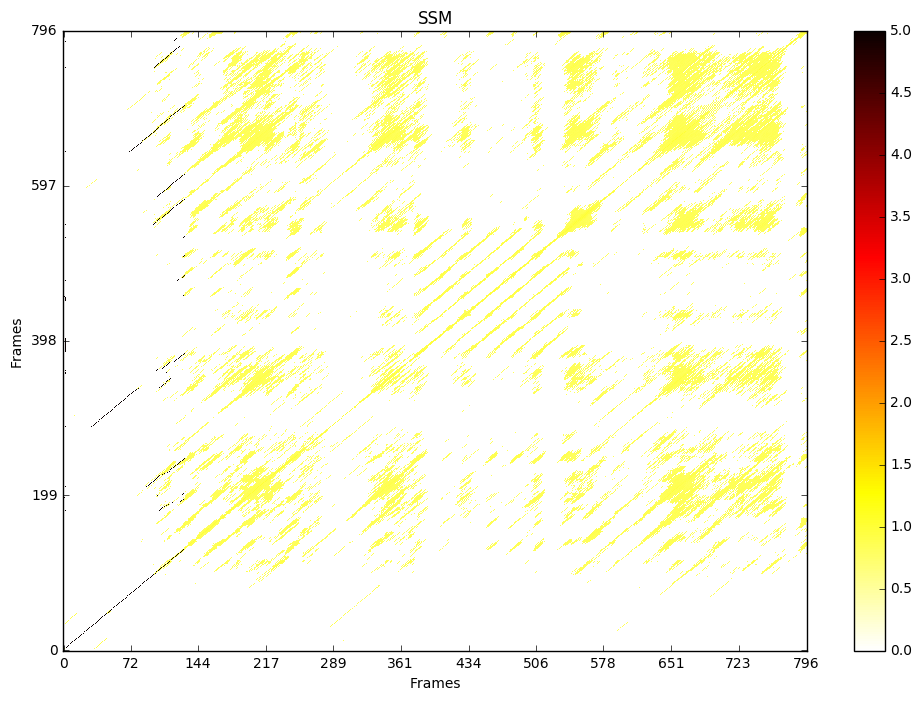

0.45 

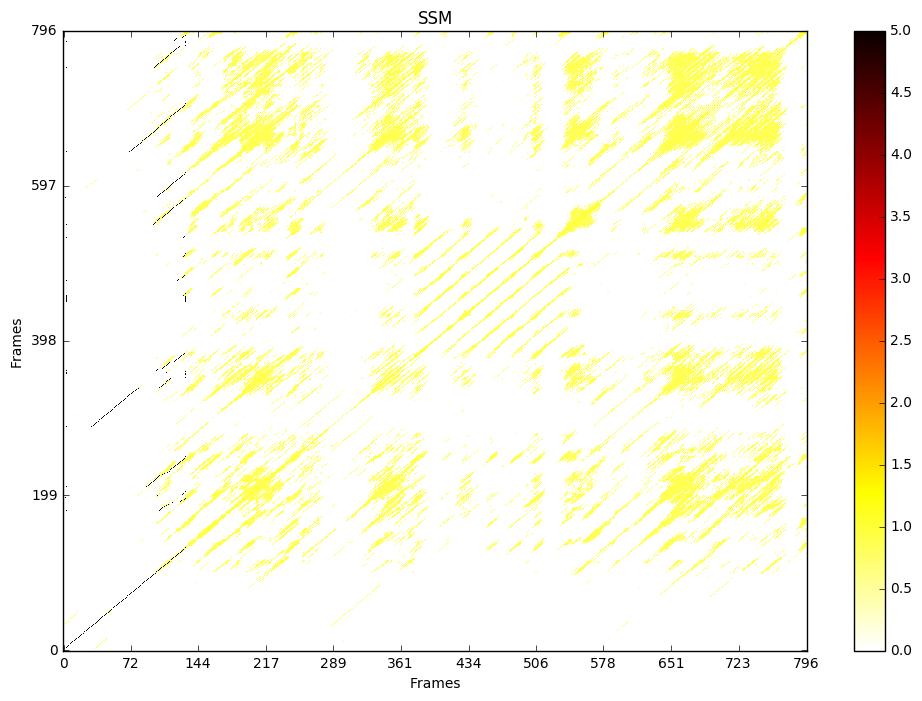

0.60 

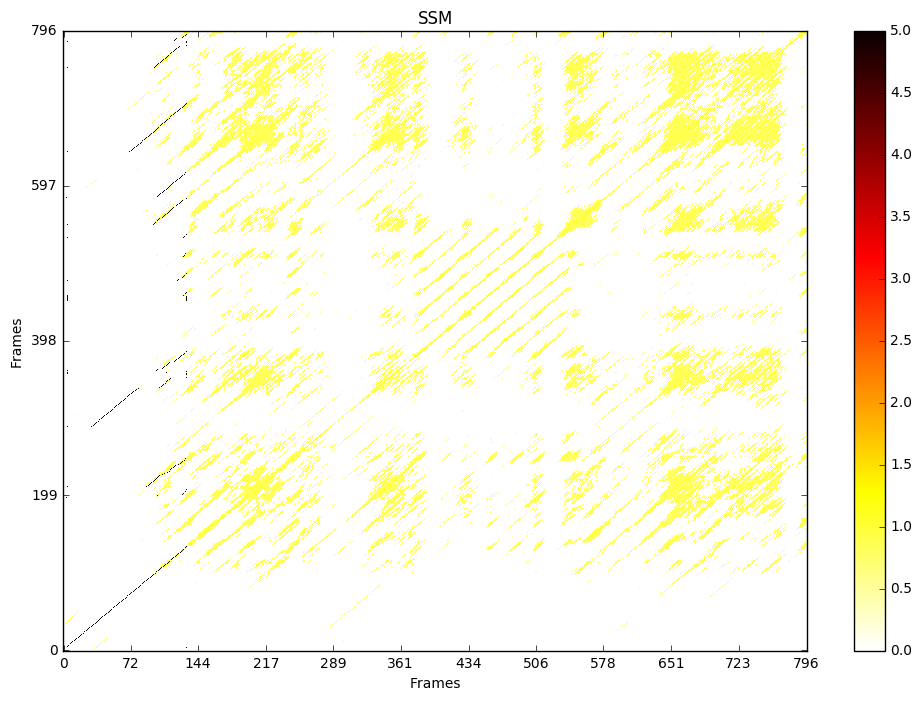

0.75 

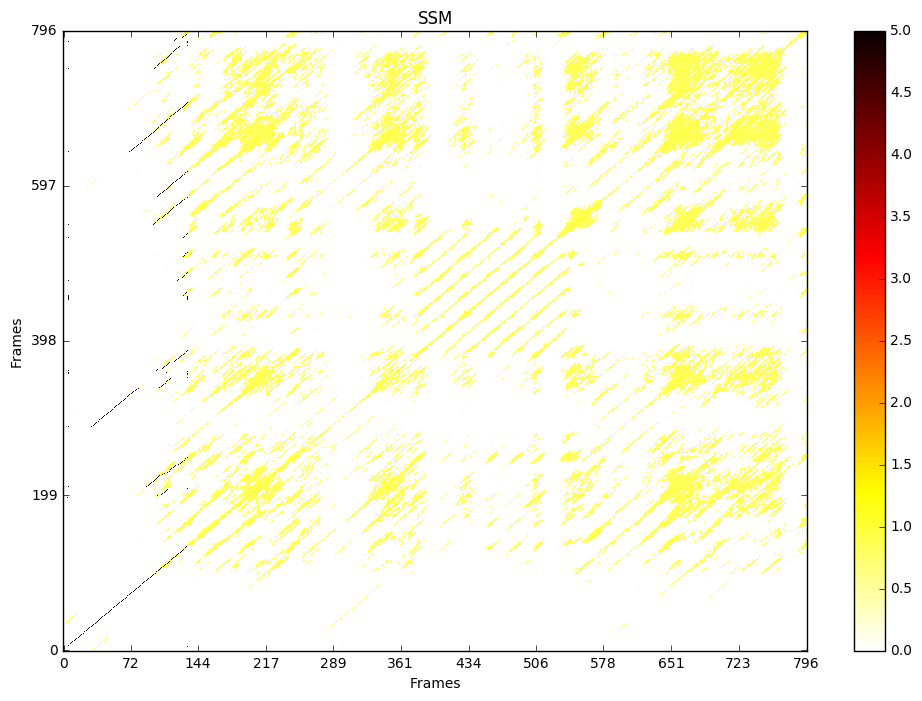

0.90 

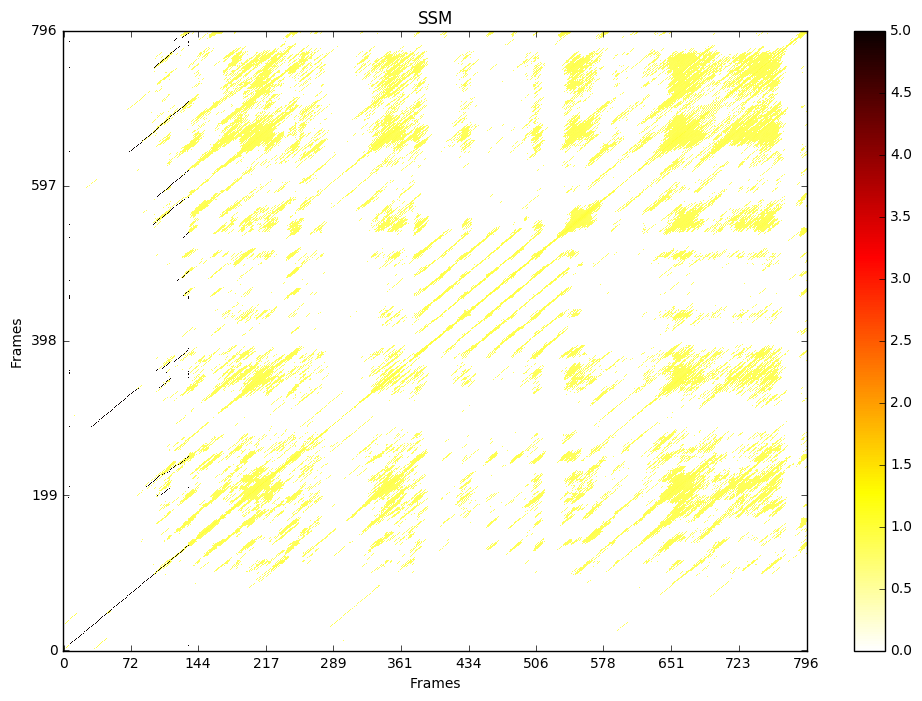

1.05 

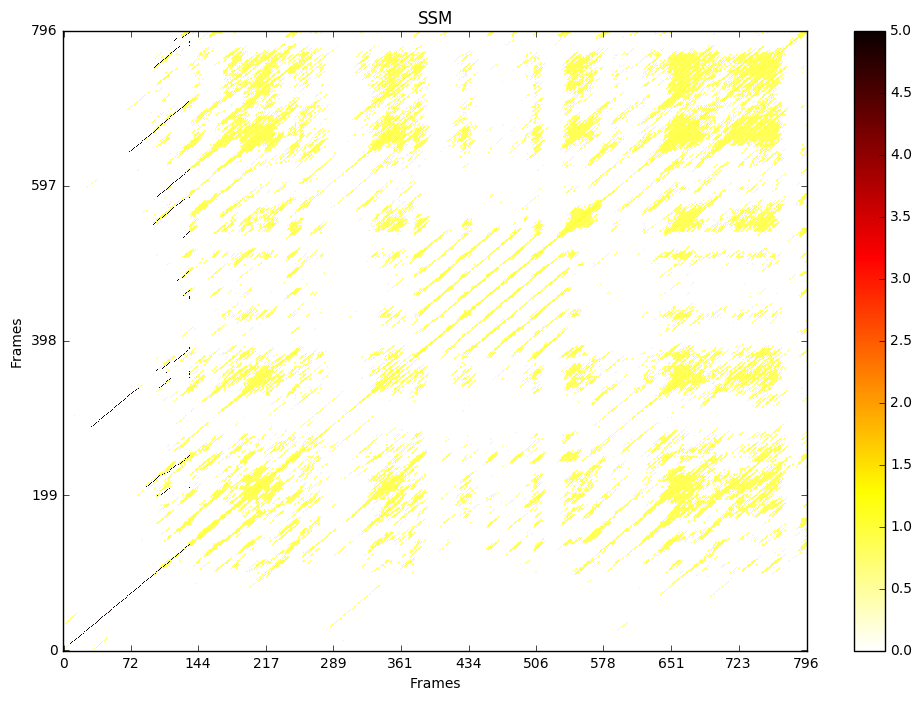

1.20 

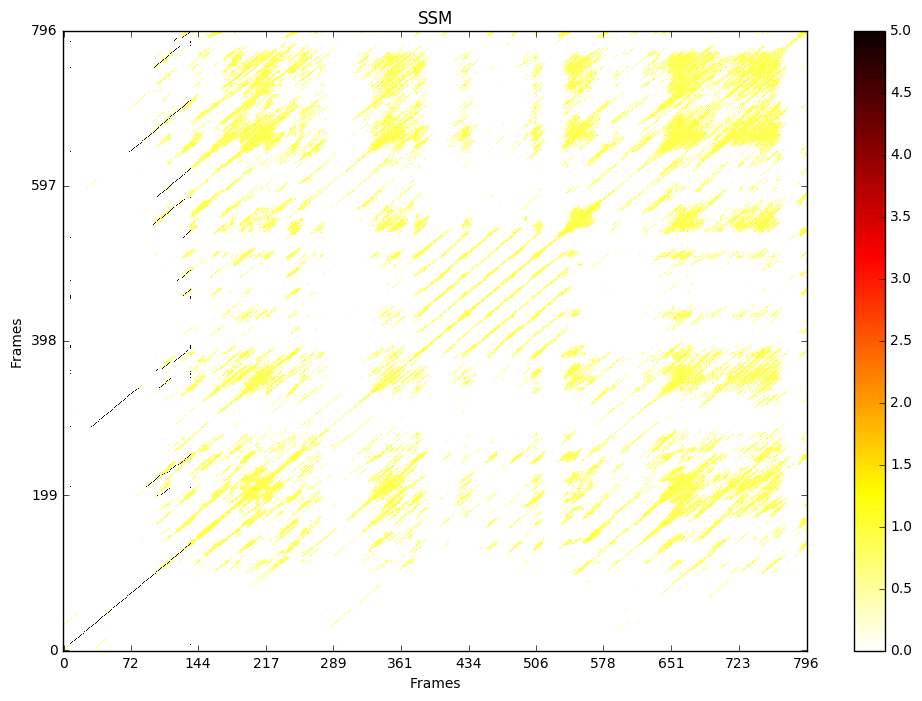

1.35 

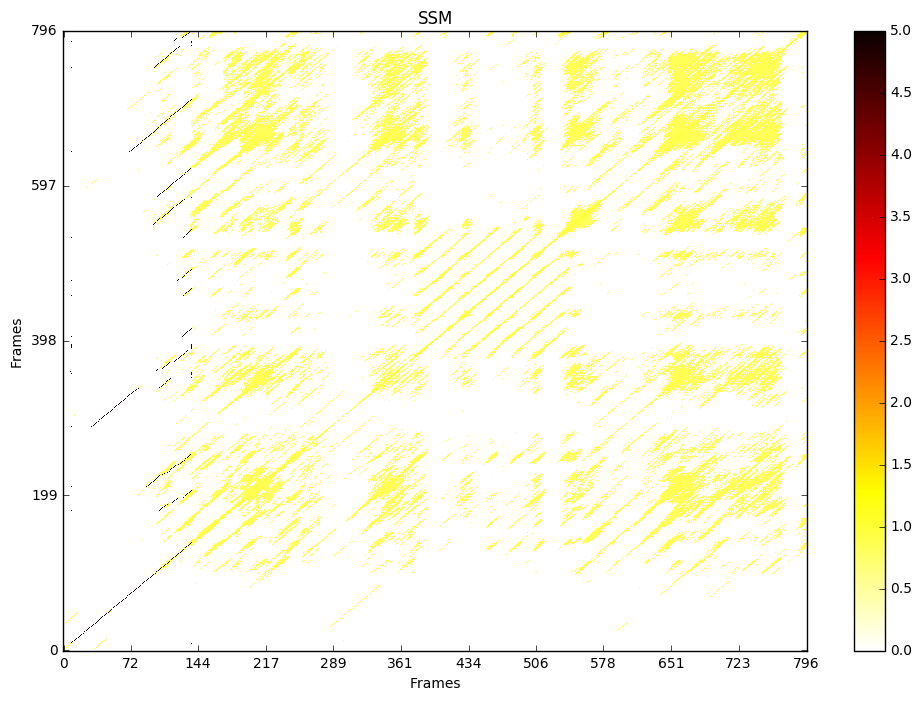

1.50 

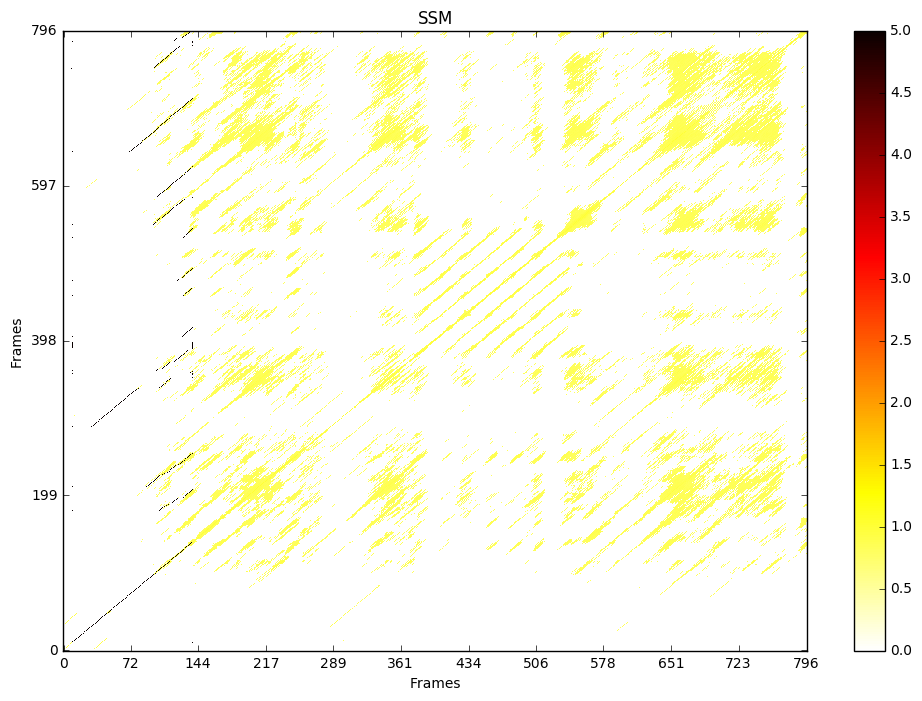

1.65 

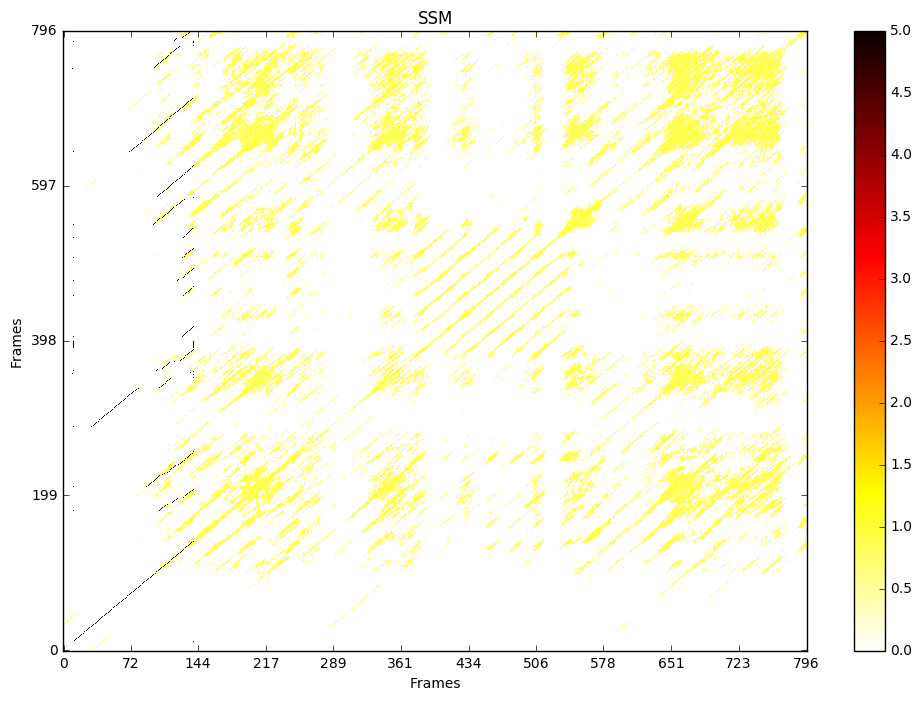

1.80 

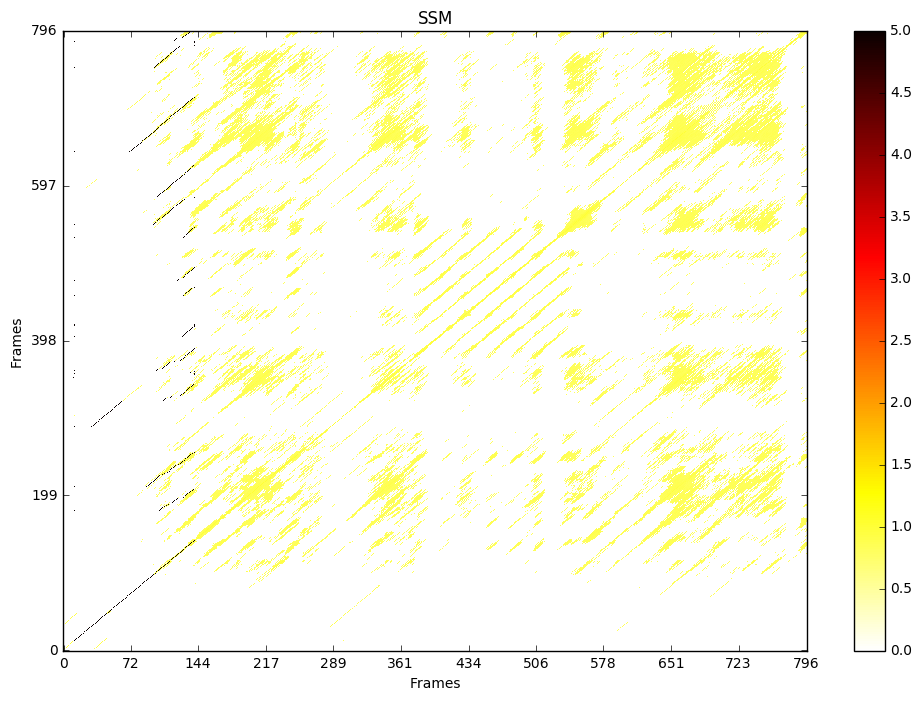

1.95 

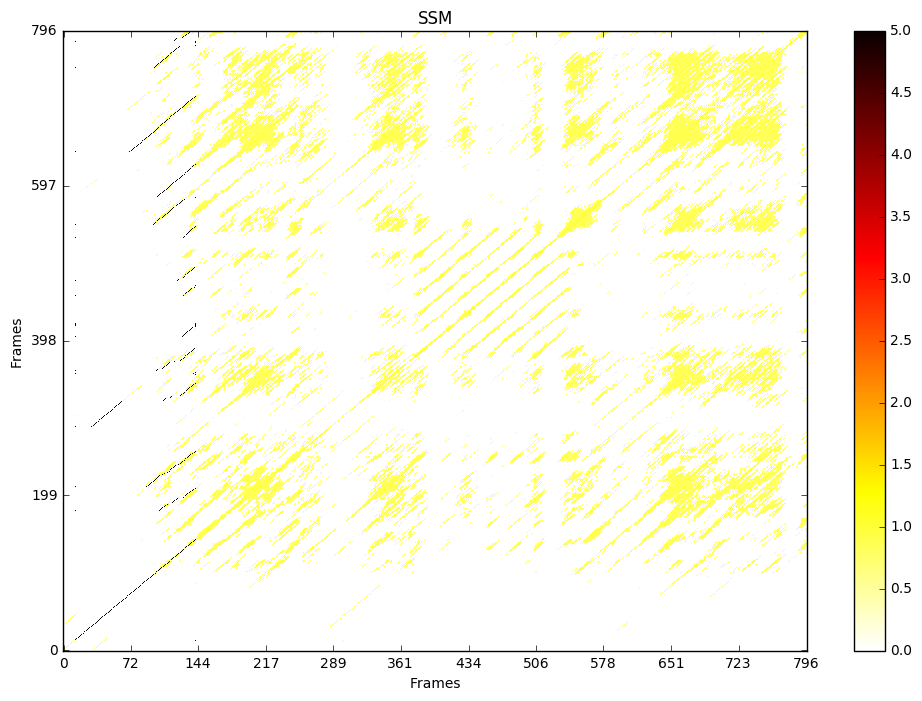

2.10 

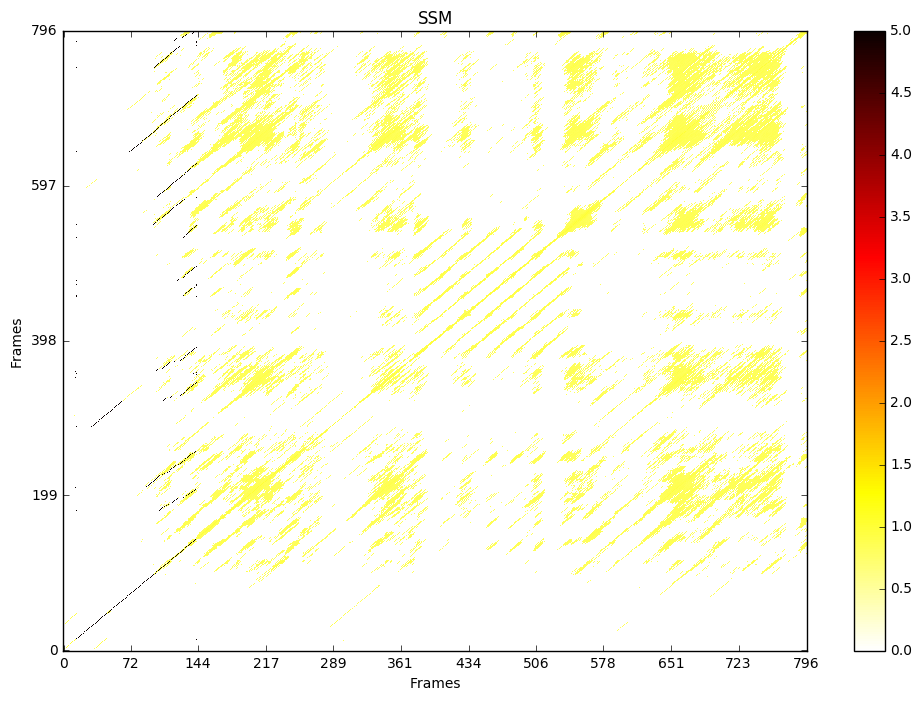

2.25 

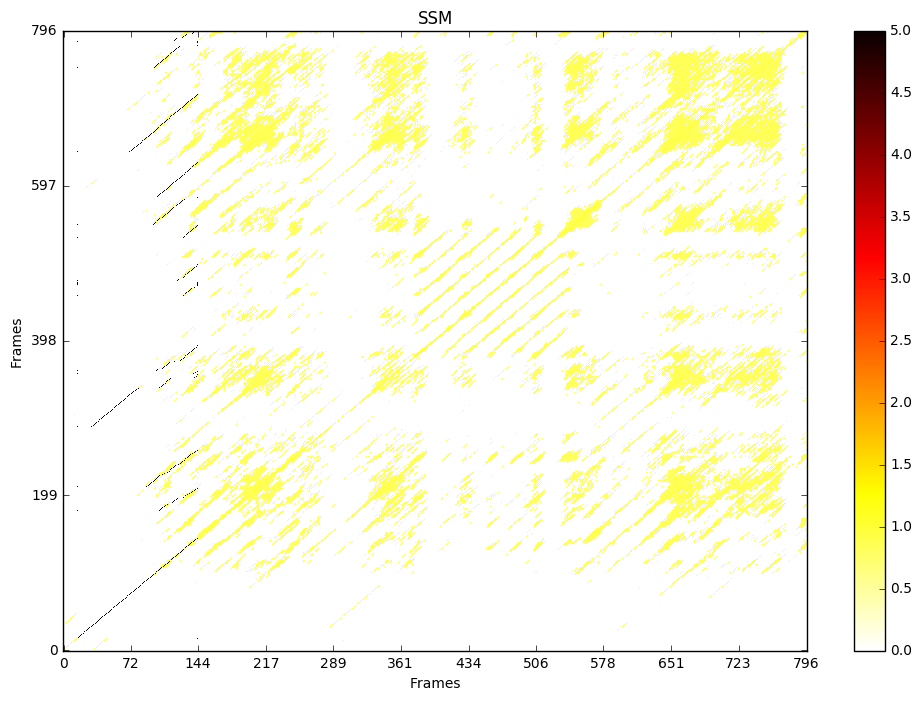

2.40 

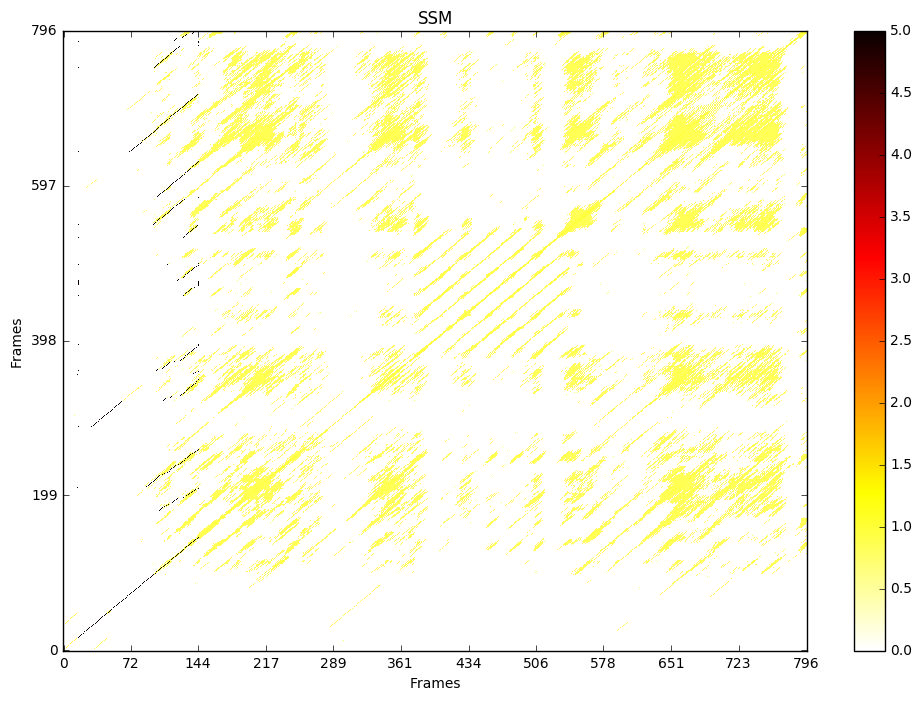

2.54 

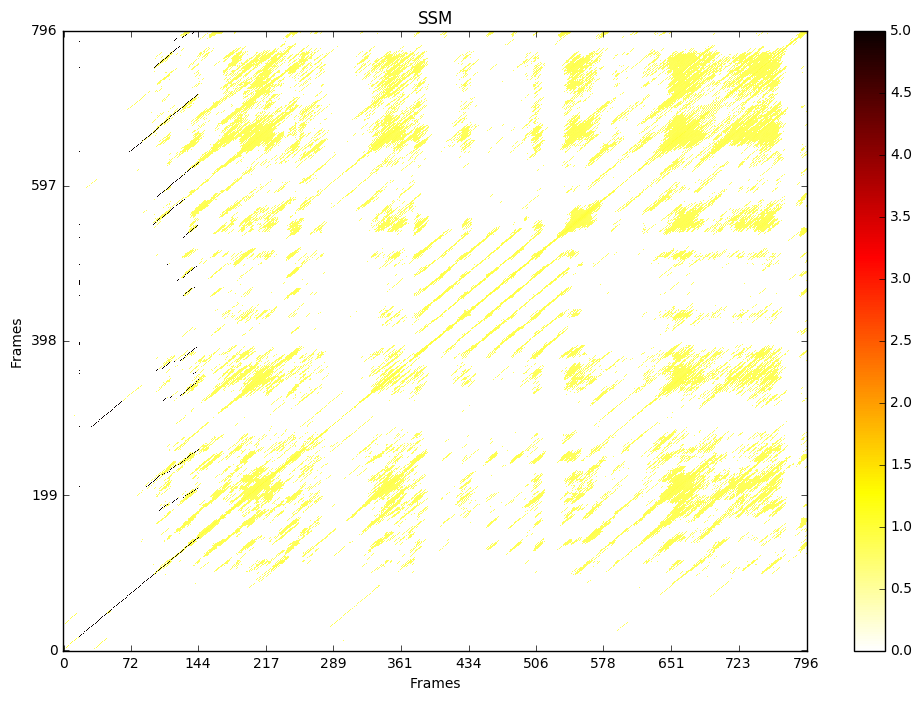

2.69 

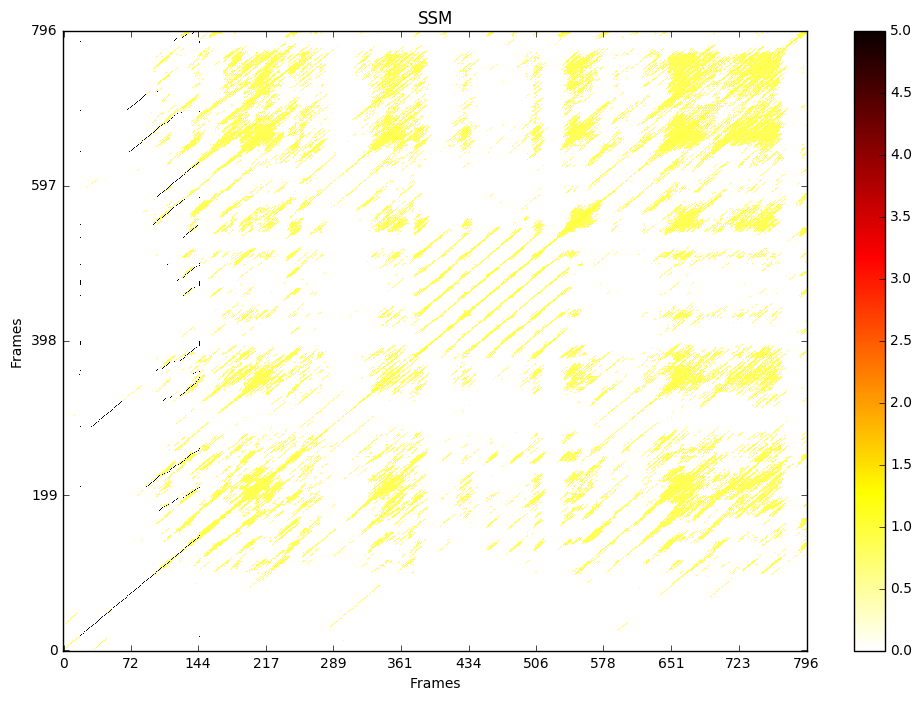

2.84 

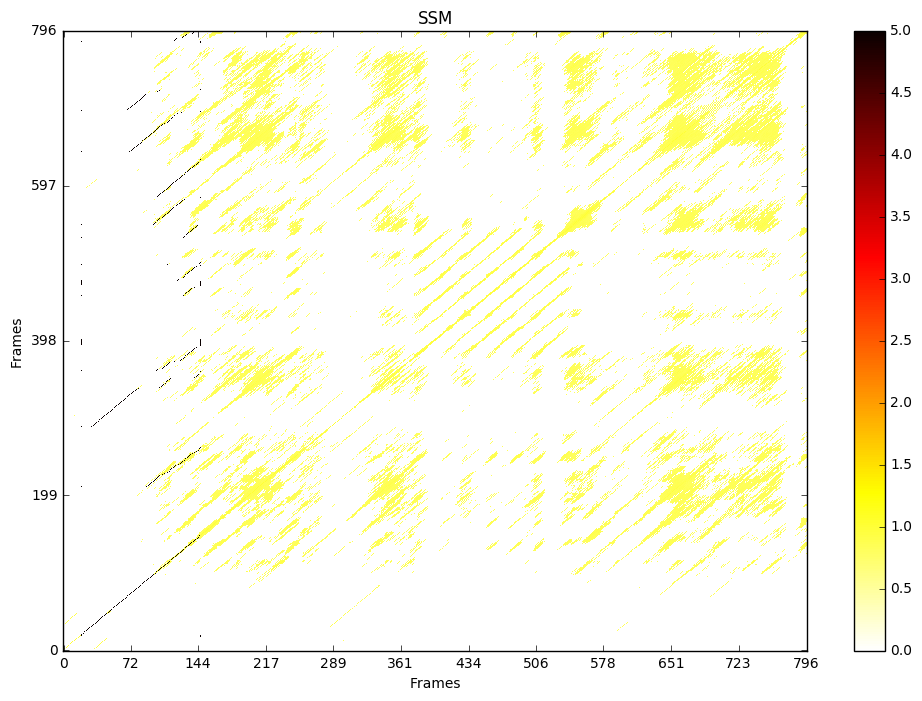

2.99 

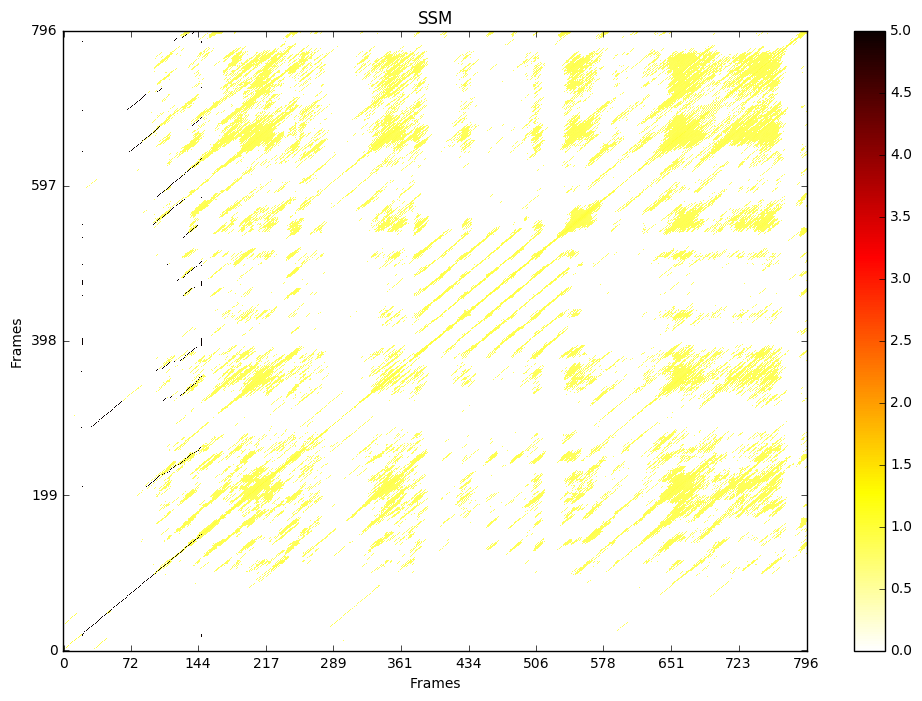

3.14 

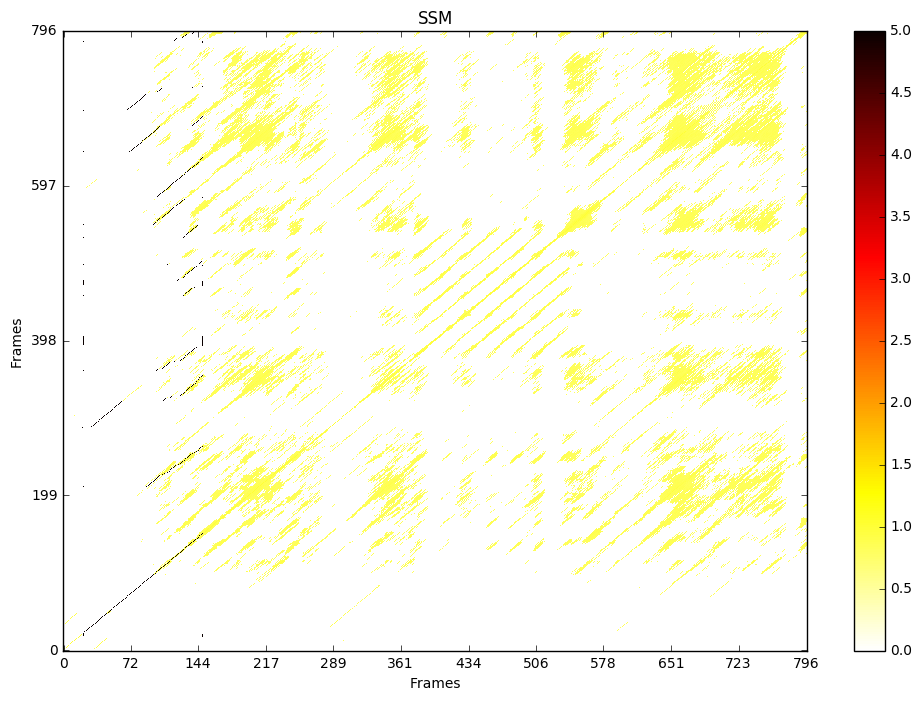

3.29 

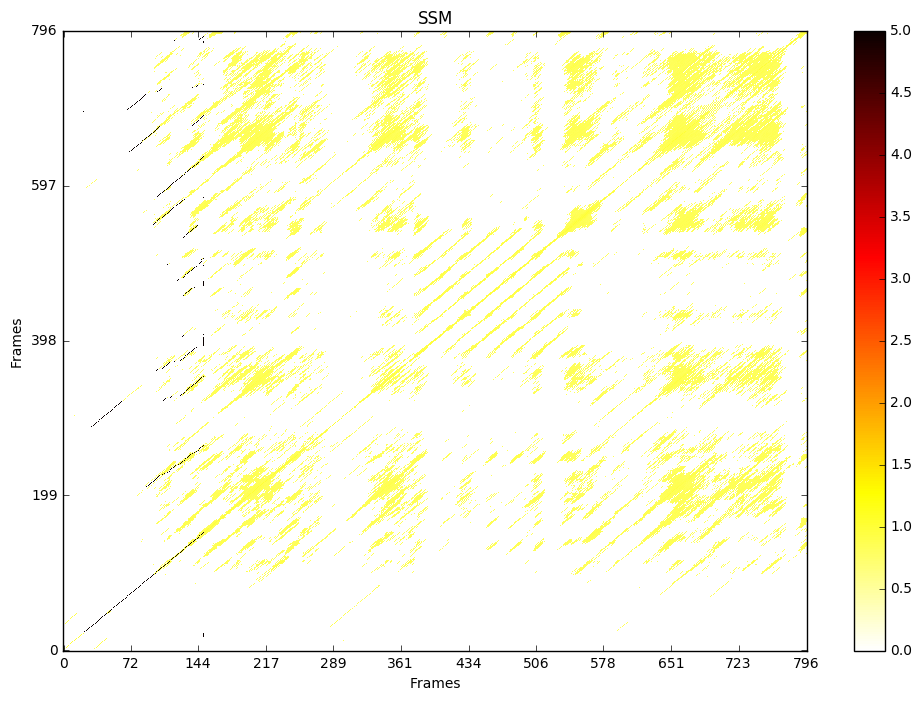

3.44 

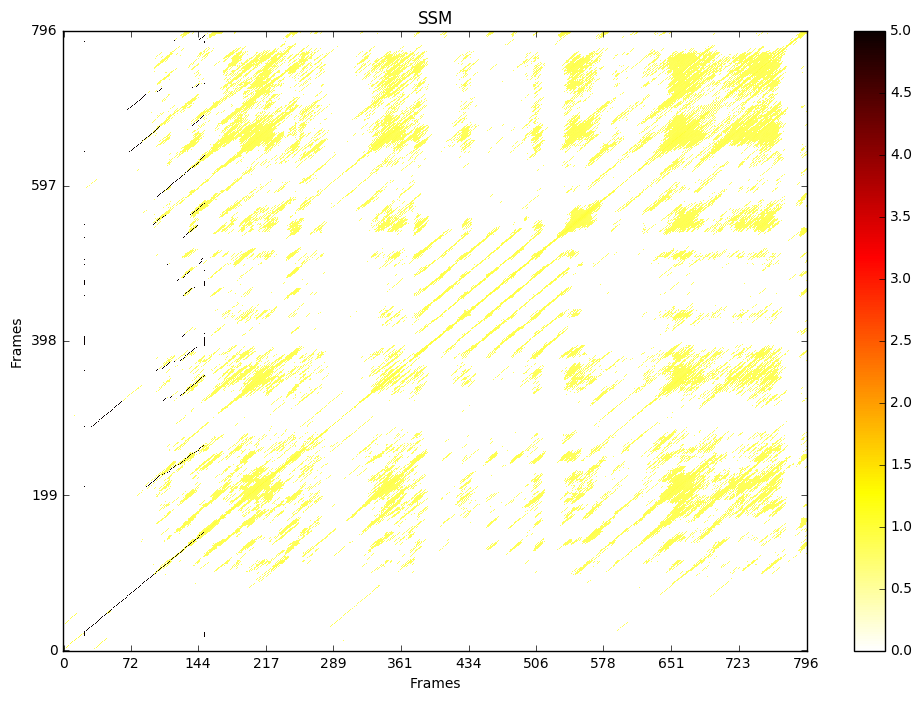

3.59 

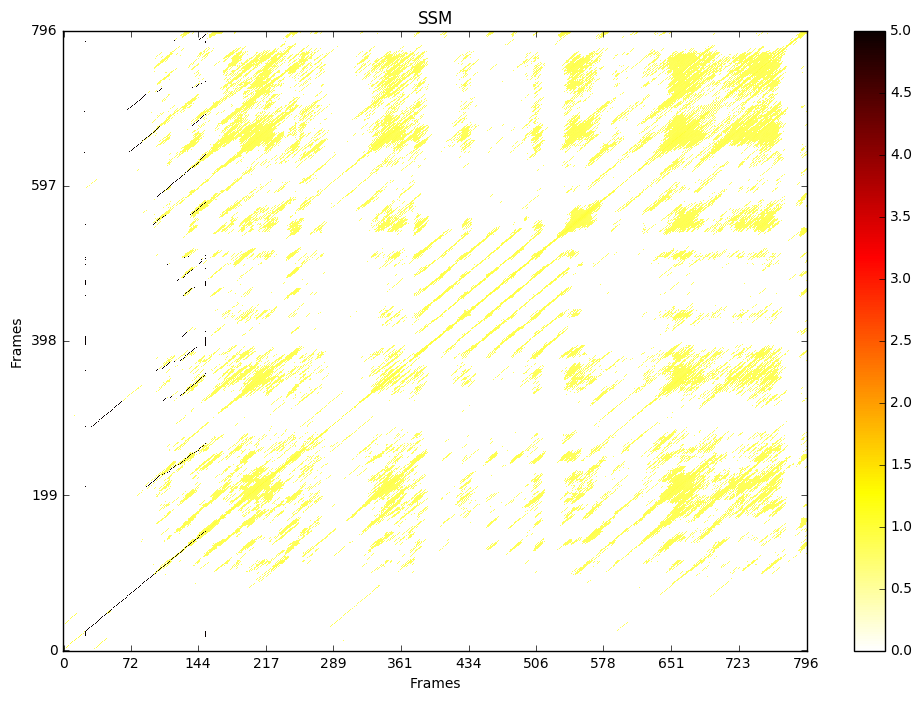

3.74 

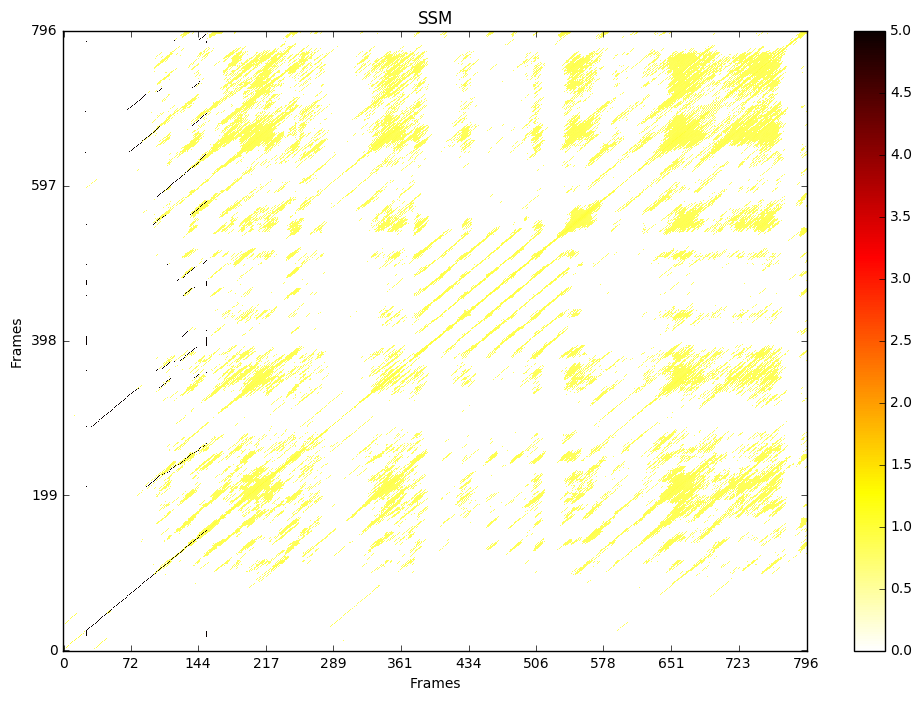

3.89 

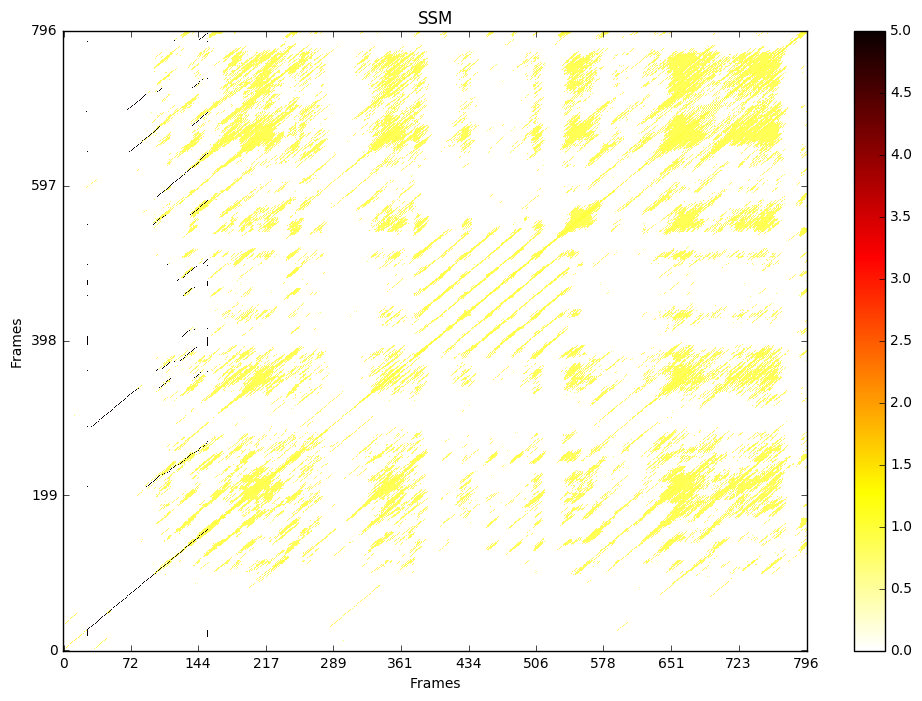

4.04 

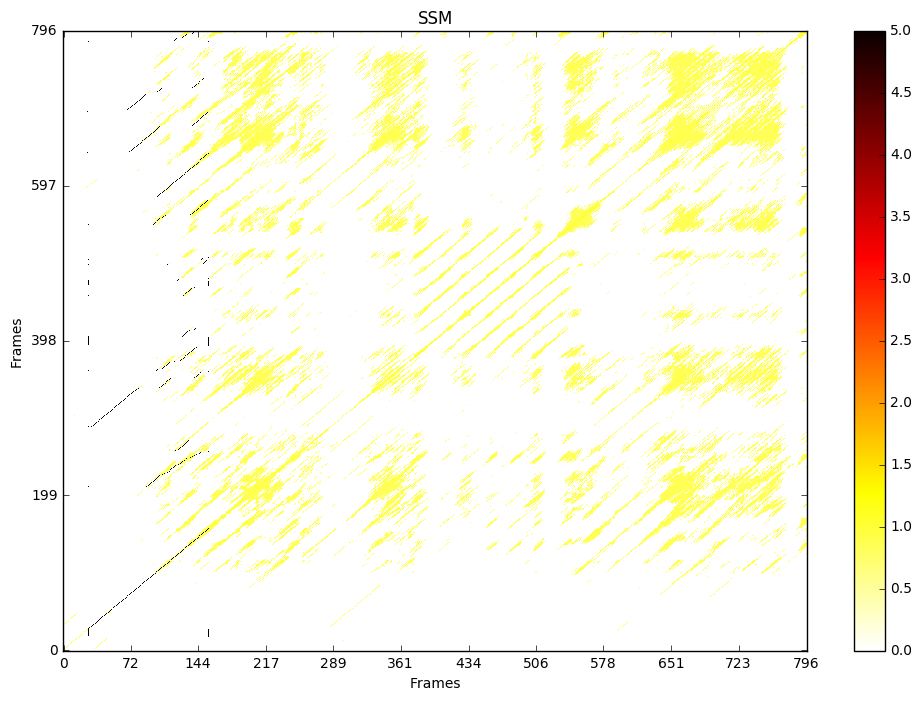

4.19 

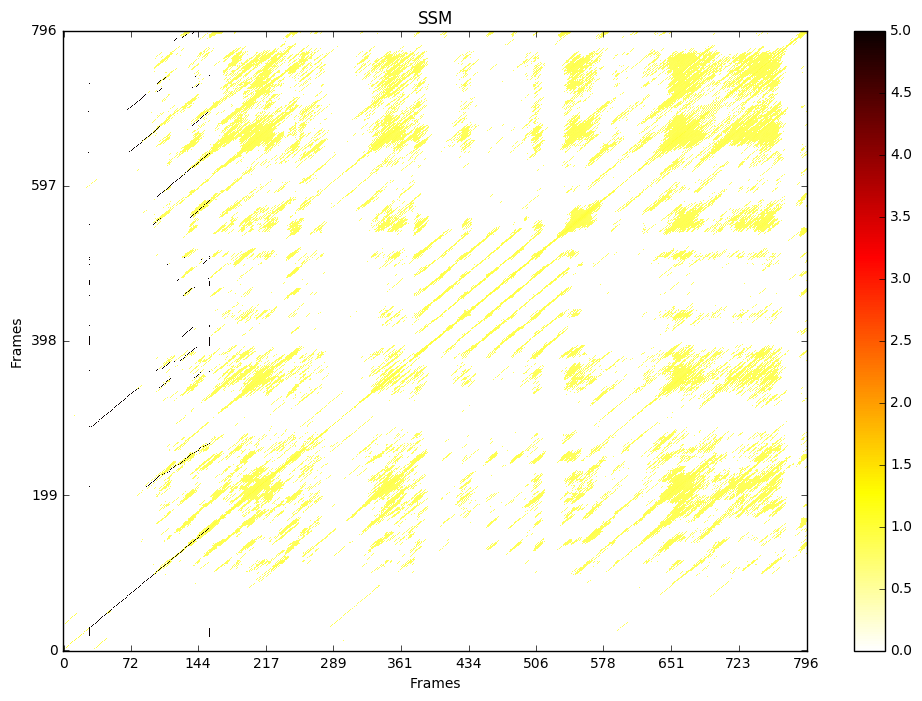

4.34 

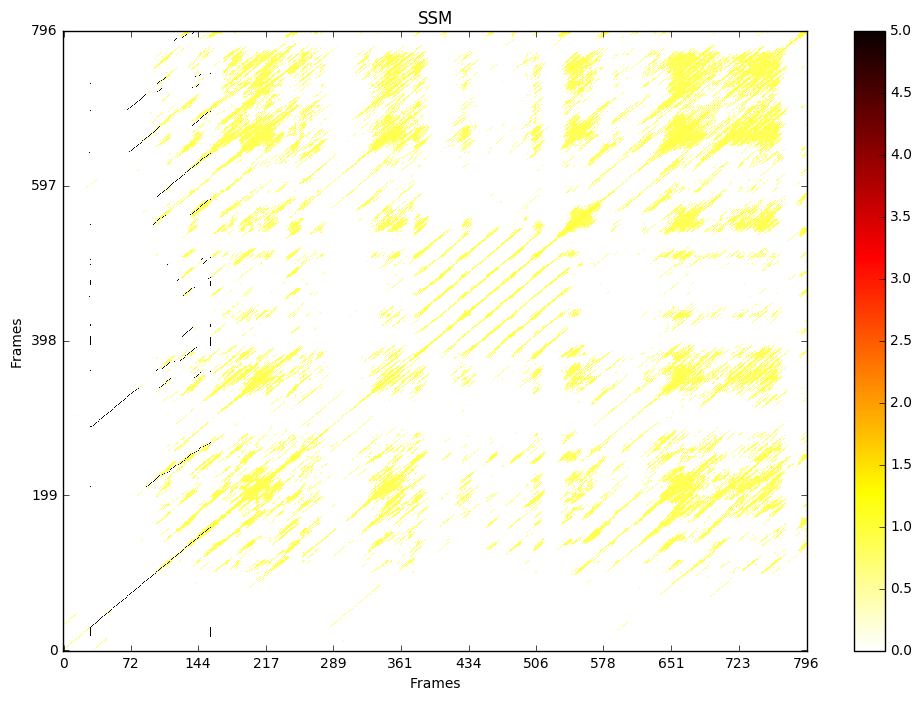

4.49 

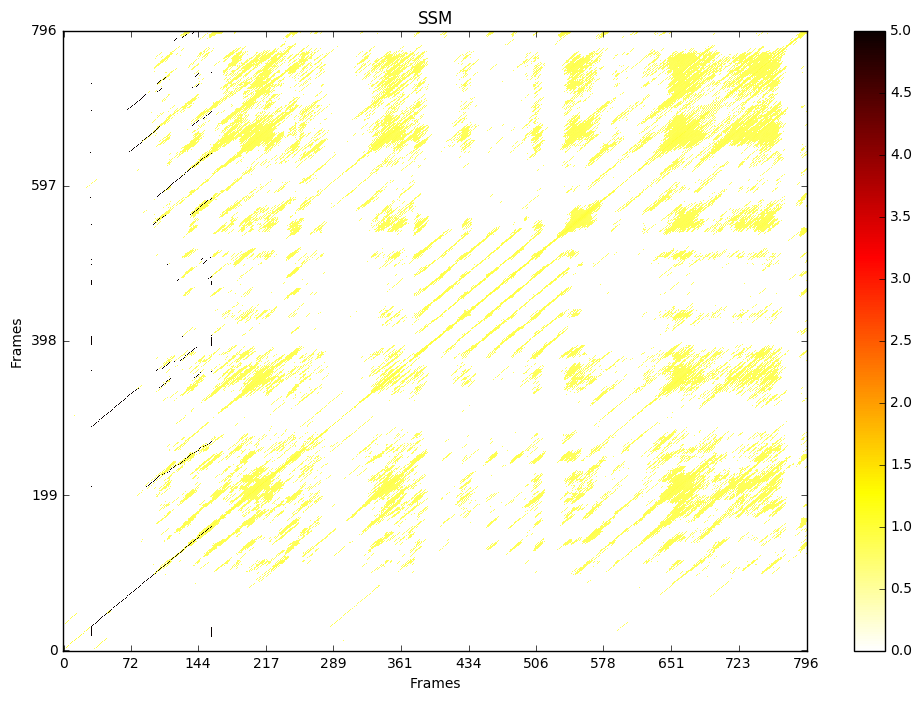

4.64 

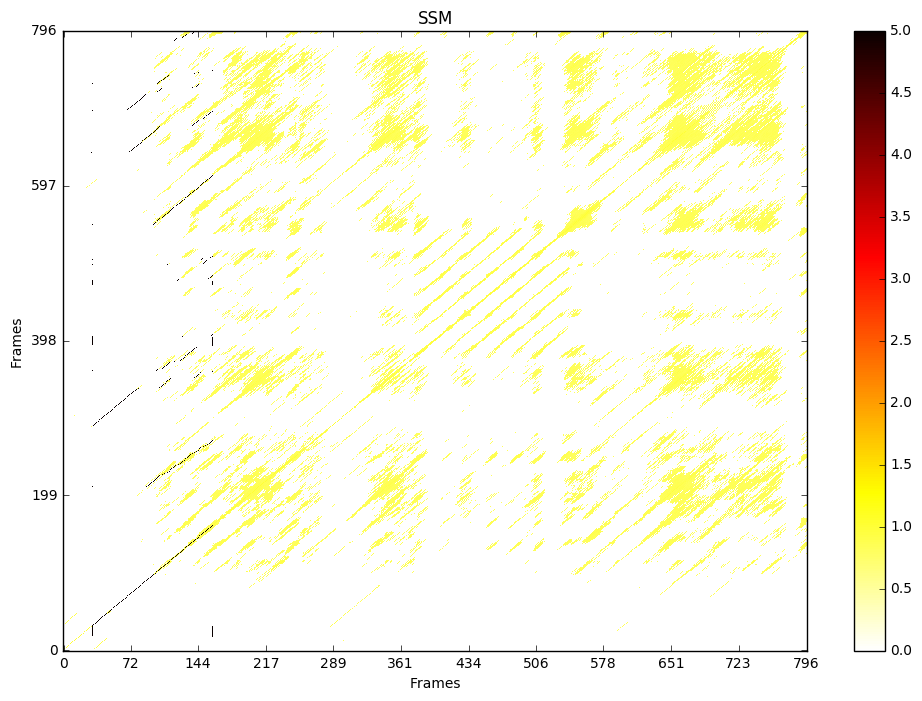

4.79 

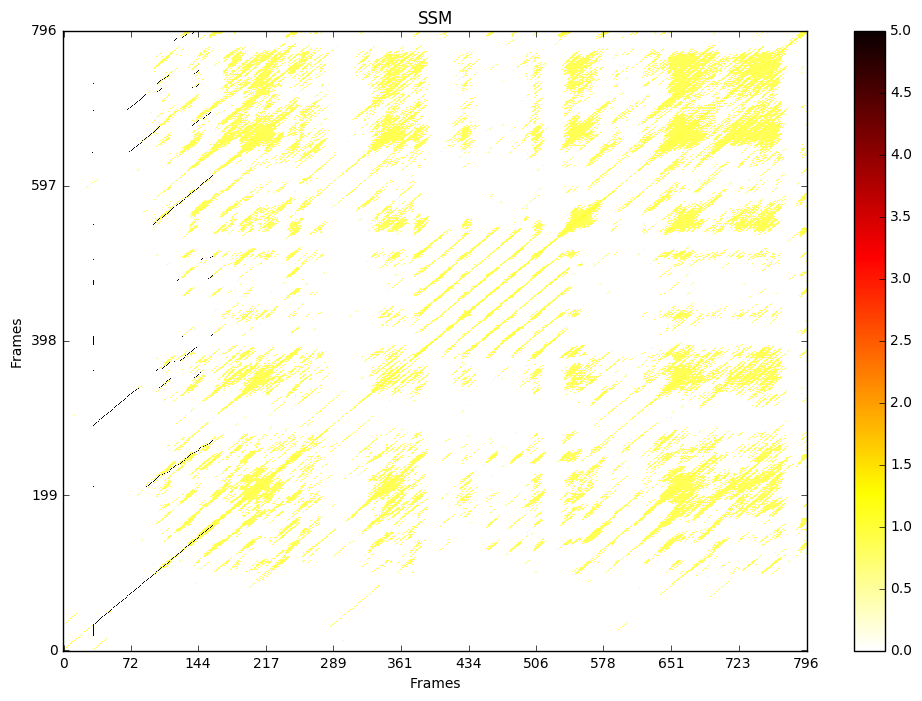

4.94 

KeyboardInterrupt: 

In [9]:
at.thumb_time(30)

In [ ]:
at.ssm.s.shape

In [ ]:
at.ssm.visualize()

In [ ]:
at.ssm.threshold(0.7)

In [ ]:
at.ssm.visualize()